In [138]:
import pandas as pd
import numpy as np
import mibian
import datetime

In [139]:
options1_df = pd.read_csv('../yahooData/results/finalData_3-11.csv', delimiter=',', engine='python', encoding = 'unicode_escape')
options2_df = pd.read_csv('../yahooData/results/finalData_3-18.csv', delimiter=',', engine='python', encoding = 'unicode_escape')
options3_df = pd.read_csv('../yahooData/results/finalData_3-25.csv', delimiter=',', engine='python', encoding = 'unicode_escape')
options4_df = pd.read_csv('../yahooData/results/finalData_4-01.csv', delimiter=',', engine='python', encoding = 'unicode_escape')
options5_df = pd.read_csv('../yahooData/results/finalData_4-08.csv', delimiter=',', engine='python', encoding = 'unicode_escape')
options6_df = pd.read_csv('../yahooData/results/finalData_4-15.csv', delimiter=',', engine='python', encoding = 'unicode_escape')
options7_df = pd.read_csv('../yahooData/results/finalData_4-22.csv', delimiter=',', engine='python', encoding = 'unicode_escape')

frames = [options1_df, options2_df, options3_df, options4_df, options5_df, options6_df]

options_df = pd.concat(frames)

In [140]:
def categorise(row):
    return ((row['Final Price'] - row['Current Price']) / row['Current Price']) * 100

options7_df['Percent Price Change'] = options7_df.apply(lambda row: categorise(row), axis=1)
options_df['Percent Price Change'] = options_df.apply(lambda row: categorise(row), axis=1)

Calls and Puts

In [141]:
# replace F/T with 0/1 for "In the Money" and "Call"
options_df = options_df.replace({'In the Money': {'True':1,'False':0}})
options_df = options_df.replace({'Call': {True:1,False:0}})
options_df = options_df.drop(columns=['Expiration Date', 'Record Time', 'Industry'])

options7_df = options7_df.replace({'In the Money': {'True':1,'False':0}})
options7_df = options7_df.replace({'Call': {True:1,False:0}})
options7_df = options7_df.drop(columns=['Expiration Date', 'Record Time', 'Industry'])

options7_df

,Symbol,Strike,Current Price,Implied Volatility,Volume,In the Money,Call,Mark,Sector,Days to Expire,Breakeven Price,Final Price,Needed Percent Change,Success,Profit,Percent Price Change
0,AAPL,120.0,164.9605,1.599611,20.0,1,1,45.450,Technology,4,165.450,161.79,0.297,0,-3.660,-1.921975
1,AAPL,135.0,164.9605,1.117192,40.0,1,1,30.500,Technology,4,165.500,161.79,0.327,0,-3.710,-1.921975
2,AAPL,145.0,164.9605,0.799318,52.0,1,1,20.525,Technology,4,165.525,161.79,0.342,0,-3.735,-1.921975
3,AAPL,149.0,164.9605,0.675784,158.0,1,1,16.550,Technology,4,165.550,161.79,0.357,0,-3.760,-1.921975
4,AAPL,150.0,164.9605,0.642582,271.0,1,1,15.550,Technology,4,165.550,161.79,0.357,0,-3.760,-1.921975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31144,CNC,87.5,85.0500,0.435553,17.0,0,1,0.050,Healthcare,0,87.550,84.41,2.939,0,-3.140,-0.752499
31145,CNC,90.0,85.0500,0.554692,24.0,0,1,0.025,Healthcare,0,90.025,84.41,5.850,0,-5.615,-0.752499
31146,CNC,80.0,85.0500,0.734378,30.0,0,0,0.075,Healthcare,0,79.925,84.41,-5.850,0,-4.485,-0.752499
31147,CNC,81.0,85.0500,0.562504,282.0,0,0,0.025,Healthcare,0,80.975,84.41,-4.733,0,-3.435,-0.752499


In [142]:
calls_df = options_df.loc[options_df['Call'] == 1]
puts_df = options_df.loc[options_df['Call'] == 0]

options7call_df = options7_df.loc[options7_df['Call'] == 1]
options7put_df = options7_df.loc[options7_df['Call'] == 0]

In [143]:
print("Before:", calls_df.shape, puts_df.shape, options7call_df.shape, options7put_df.shape)
calls_df = calls_df[calls_df['Sector'] == 'Technology']
puts_df = puts_df[puts_df['Sector'] == 'Technology']

options7call_df = options7call_df[options7call_df['Sector'] == 'Technology']
options7put_df = options7put_df[options7put_df['Sector'] == 'Technology']
print("After:", calls_df.shape, puts_df.shape, options7call_df.shape, options7put_df.shape)

Before: (199867, 16) (186636, 16) (15853, 16) (15296, 16)
After: (47426, 16) (44529, 16) (3241, 16) (3129, 16)


Black Scholes

In [144]:
def callDelta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callDelta

def callTheta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callTheta

def callRho(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callRho

def callVega(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.vega

def callGamma(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.gamma

def putDelta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putDelta

def putTheta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putTheta

def putRho(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putRho

def putVega(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.vega

def putGamma(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.gamma

In [145]:
start_time = time.time()

calls_df['Delta'] = calls_df.apply(lambda row: callDelta(row), axis=1)
calls_df['Theta'] = calls_df.apply(lambda row: callTheta(row), axis=1)
calls_df['Rho'] = calls_df.apply(lambda row: callRho(row), axis=1)
calls_df['Vega'] = calls_df.apply(lambda row: callVega(row), axis=1)
calls_df['Gamma'] = calls_df.apply(lambda row: callGamma(row), axis=1)

options7call_df['Delta'] = options7call_df.apply(lambda row: callDelta(row), axis=1)
options7call_df['Theta'] = options7call_df.apply(lambda row: callTheta(row), axis=1)
options7call_df['Rho'] = options7call_df.apply(lambda row: callRho(row), axis=1)
options7call_df['Vega'] = options7call_df.apply(lambda row: callVega(row), axis=1)
options7call_df['Gamma'] = options7call_df.apply(lambda row: callGamma(row), axis=1)

puts_df['Delta'] = puts_df.apply(lambda row: putDelta(row), axis=1)
puts_df['Theta'] = puts_df.apply(lambda row: putTheta(row), axis=1)
puts_df['Rho'] = puts_df.apply(lambda row: putRho(row), axis=1)
puts_df['Vega'] = puts_df.apply(lambda row: putVega(row), axis=1)
puts_df['Gamma'] = puts_df.apply(lambda row: putGamma(row), axis=1)

options7put_df['Delta'] = options7put_df.apply(lambda row: putDelta(row), axis=1)
options7put_df['Theta'] = options7put_df.apply(lambda row: putTheta(row), axis=1)
options7put_df['Rho'] = options7put_df.apply(lambda row: putRho(row), axis=1)
options7put_df['Vega'] = options7put_df.apply(lambda row: putVega(row), axis=1)
options7put_df['Gamma'] = options7put_df.apply(lambda row: putGamma(row), axis=1)

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

Took 0:26:59.016356 seconds


Technology stocks

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer

In [108]:
# choose tech sector
tech_df = puts_df[puts_df.Sector=='Technology']
tech_df = tech_df.drop(columns=['Call', 'Sector'])

stock_frames = []
tech_stock_names = tech_df['Symbol'].unique()

# output
y = tech_df['Success']
tech_df = tech_df.drop(columns=['Success'])

# columns to normalize
col_to_norm = ['Strike', 'Current Price', 'Implied Volatility', 'Volume', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

# normalize one stock at a time
for stock_name in tech_stock_names:
    stock = tech_df[tech_df.Symbol == stock_name]
    stock = stock.drop(columns=['Symbol'])
    
    stock[col_to_norm] = StandardScaler().fit_transform(stock[col_to_norm])
    
    scaled_stock = pd.DataFrame(stock)
    stock_frames.append(scaled_stock)
    
normalized_tech_df = pd.concat(stock_frames)
normalized_tech_df.columns = ['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

# input
X = normalized_tech_df

In [109]:
# choose tech sector
tech7_df = puts7_df[puts7_df.Sector=='Technology']
tech7_df = tech7_df.drop(columns=['Call', 'Sector'])

stock_frames = []
tech_stock_names = tech7_df['Symbol'].unique()

# output
y7 = tech7_df['Success']
tech7_df = tech7_df.drop(columns=['Success'])

# columns to normalize
col_to_norm = ['Strike', 'Current Price', 'Implied Volatility', 'Volume', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

# normalize one stock at a time
for stock_name in tech_stock_names:
    stock = tech7_df[tech7_df.Symbol == stock_name]
    stock = stock.drop(columns=['Symbol'])
    
    stock[col_to_norm] = StandardScaler().fit_transform(stock[col_to_norm])
    
    scaled_stock = pd.DataFrame(stock)
    stock_frames.append(scaled_stock)
    
normalized_tech7_df = pd.concat(stock_frames)
normalized_tech7_df.columns = ['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

# input
X7 = normalized_tech7_df

In [ ]:
normalized_tech_df

In [ ]:
normalized_tech7_df

In [213]:
train1_6 = puts_df
test7 = options7put_df

In [214]:
# columns to normalize
train1_6 = train1_6.drop(columns=['Call', 'Sector'])
y = train1_6['Success']
train1_6 = train1_6.drop(columns=['Success'])

col_to_norm = ['Strike', 'Current Price', 'Implied Volatility', 'Volume', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

tech_stock_names = train1_6['Symbol'].unique()

stock_frames = []
# normalize one stock at a time
for stock_name in tech_stock_names:
    stock = train1_6[train1_6.Symbol == stock_name]
    stock = stock.drop(columns=['Symbol'])
    
    stock[col_to_norm] = StandardScaler().fit_transform(stock[col_to_norm])
    
    scaled_stock = pd.DataFrame(stock)
    stock_frames.append(scaled_stock)
    
normalized_train1_6_df = pd.concat(stock_frames)
normalized_train1_6_df.columns = ['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma']

In [215]:
print(normalized_train1_6_df.shape)
print(y.shape)

(44529, 17)
(44529,)


In [216]:
# columns to normalize
test7 = test7.drop(columns=['Call', 'Sector'])
y7 = test7['Success']
test7 = test7.drop(columns=['Success'])

col_to_norm = ['Strike', 'Current Price', 'Implied Volatility', 'Volume', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

tech_stock_names = test7['Symbol'].unique()
stock_frames = []
# normalize one stock at a time
for stock_name in tech_stock_names:
    stock = test7[test7.Symbol == stock_name]
    stock = stock.drop(columns=['Symbol'])
    
    stock[col_to_norm] = StandardScaler().fit_transform(stock[col_to_norm])
    
    scaled_stock = pd.DataFrame(stock)
    stock_frames.append(scaled_stock)
    
normalized_test7_df = pd.concat(stock_frames)
normalized_test7_df.columns = ['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma']

normalized_test7_df

,Strike,Current Price,Implied Volatility,Volume,In the Money,Mark,Days to Expire,Breakeven Price,Final Price,Needed Percent Change,Profit,Percent Price Change,Delta,Theta,Rho,Vega,Gamma
30,-1.856594,-1.028994,1.084445,-0.402714,0,-0.589113,1.192733,-2.043743,-2.842171e-14,-1.632201,-2.043743,1.026371,-0.000335,-0.002397,-0.000006,0.000212,0.000078
31,-1.332706,-1.028994,0.722774,-0.402148,0,-0.587262,1.192733,-1.410763,-2.842171e-14,-1.198579,-1.410763,1.026371,-0.001299,-0.007072,-0.000024,0.000739,0.000324
32,-1.070762,-1.028994,0.481660,-0.407350,0,-0.586337,1.192733,-1.094273,-2.842171e-14,-0.981768,-1.094273,1.026371,-0.001958,-0.009021,-0.000036,0.001074,0.000536
33,-0.808818,-1.028994,0.160175,-0.376908,0,-0.587262,1.192733,-0.777149,-2.842171e-14,-0.765386,-0.777149,1.026371,-0.001900,-0.007143,-0.000035,0.001045,0.000641
34,-0.546873,-1.028994,-0.020660,-0.381801,0,-0.585412,1.192733,-0.460975,-2.842171e-14,-0.548361,-0.460975,1.026371,-0.004526,-0.013610,-0.000083,0.002285,0.001608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26179,-0.787817,0.372136,0.189555,-0.799716,0,-0.751042,-1.338340,-0.662235,0.000000e+00,-0.863207,-0.662235,-0.380939,-0.008454,-0.021953,-0.000024,0.001222,0.012058
26180,-0.283614,0.372136,1.458569,-0.553650,0,-0.603824,-1.338340,-0.095869,0.000000e+00,-0.487730,-0.095869,-0.380939,-0.080158,-0.187214,-0.000225,0.007905,0.059204
26181,0.220589,0.372136,0.135324,0.307583,0,-0.640628,-1.338340,0.549159,0.000000e+00,-0.155165,0.549159,-0.380939,-0.093177,-0.156809,-0.000261,0.008847,0.088521
31011,0.220589,-1.582782,-1.686849,-0.061517,0,-0.419801,-2.131431,0.454764,0.000000e+00,0.699261,0.454764,1.594918,-0.447317,-0.276199,-0.000610,0.014503,0.566213


Random Forest

In [217]:
X = normalized_train1_6_df
X7 = normalized_test7_df

In [51]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=5) # 80/20 train/test

In [209]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# prediction on test set
y_pred=clf.predict(X7)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y7, y_pred))

Accuracy: 0.5238095238095238


In [85]:
feature_imp = pd.Series(clf.feature_importances_,index=normalized_tech_df.columns).sort_values(ascending=False)
feature_imp

Percent Price Change     0.128009
Current Price            0.122937
Implied Volatility       0.104291
Needed Percent Change    0.097155
Mark                     0.091562
Days to Expire           0.091317
Profit                   0.078757
Volume                   0.078032
Breakeven Price          0.077148
Final Price              0.070565
Strike                   0.055139
In the Money             0.005089
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


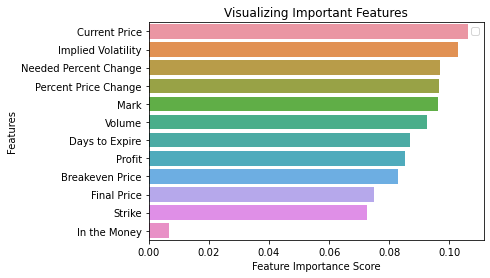

In [54]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [218]:
X = normalized_train1_6_df[['Implied Volatility', 'Days to Expire']]
X7 = normalized_test7_df[['Implied Volatility', 'Days to Expire']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=5) # 80/20 train/test

In [219]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# prediction on test set
y_pred=clf.predict(X7)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y7, y_pred))

Accuracy: 0.4768296580377117


In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# prediction on test set
y_pred=clf.predict(X7)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y7, y_pred))

Calls: Accuracy: 0.9096314205358464 \
Calls (top6 features (above 0.09)): Accuracy: 0.903858489169586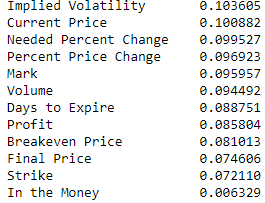

Puts: Accuracy: 0.7065334277546096
Puts (top5 features (above 0.09)): Accuracy: 0.7317124347575209 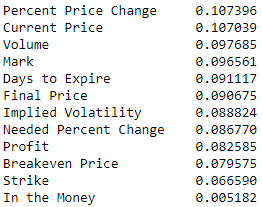

calls (6 week / week): Accuracy: 0.980561555075594
calls (top5): Accuracy: 0.980561555075594 (something is not right)